<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/thompson-sampling-fc28817eacb8)) <b><font size='3ptx'>Over the last few parts in this series we’ve been looking at increasingly complex methods of solving the [Multi-Armed Bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit). We’ve now reached the final and most complex of all the methods we’re going to look at: [Thompson Sampling](https://en.wikipedia.org/wiki/Thompson_sampling).</font></b>

All code for the bandit algorithms and testing framework can be found on [github: Multi_Armed_Bandits](https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits)
* <b><font size='3ptx'><a href='#sect1'>Thompson Sampling</a></font></b>
* <b><font size='3ptx'><a href='#sect2'>Gaussian Thompson Sampling</a></font></b>
* <b><font size='3ptx'><a href='#sect4'>Summary</a></font></b>

<a id='sect1'></a>
## <font color='darkblue'>Thompson Sampling</font>
* <font size='3ptx'><b><a href='#sect1_1'>Bernoulli Thompson Sampling</a></b></font>
* <font size='3ptx'><b><a href='#sect1_2'>Bernoulli Socket Implementation</a></b></font>
* <font size='3ptx'><b><a href='#sect1_3'>Experiment Results</a></b></font>

<font size='3ptx'>Up until now, all of the methods we’ve seen for tackling the Bandit Problem have selected their actions based on the current averages of the rewards received from those actions. <b>Thompson Sampling</b> (<font color='brown'>also sometimes referred to as the Bayesian Bandits algorithm</font>) <b>takes a slightly different approach; rather than just refining an estimate of the mean reward it extends this, to instead build up a probability model from the obtained rewards, and then samples from this to choose an action.</b>
    
<b>In this way, not only is an increasingly accurate estimate of the possible reward obtained, but the model also provides a level of confidence in this reward, and this confidence increases as more samples are collected</b>. This process of updating your beliefs as more evidence becomes available is known as Bayesian Inference.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import socket_utils
import scipy.stats as stats
import socket_utils

In [18]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
    """ a random tie-breaking argmax"""
    values = np.asarray(value_list)
    return np.argmax(np.random.random(values.shape) * (values==values.max()))


def plot_nd_sockets(ax, sockets, socket_probabilities ):
    x = np.linspace(0.0,16.0,200)
    trials = sum([socket.n for socket in sockets])              
    for socket in sockets:
                        
        y = stats.norm.pdf( x, socket.μ_0, np.sqrt(1./socket.τ_0) )        
        p = ax.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
        c = p[0].get_markeredgecolor()
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )
        ax.autoscale(tight = "True")
        ax.set_title(f"{trials} Trials")
        ax.legend()
        ax.autoscale(tight=True)
        

def plot_sockets(ax, sockets, socket_probabilities):
    beta = stats.beta
    x = np.linspace(0.0, 1.0, 200)
    trials = sum([socket.n for socket in sockets])
    
    colors = ["green","red","blue"]
    c_index = 0    
    
    for i in range(len(socket_probabilities)):        
        c = colors[c_index]
        y = stats.beta( sockets[i].α, sockets[i].β )
        ax.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        ax.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        ax.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        ax.autoscale(tight = "True")
        ax.set_title(f"{trials} Trials")
        ax.legend()
        ax.autoscale(tight=True)
        c_index += 1

<a id='sect1_1'></a>
### <font color='darkgreen'>Bernoulli Thompson Sampling</font>
As an introduction, and to make things easier to work with, let’s simplify the power socket problem.

Now, instead of each socket returning a varying amount of charge, each socket will either return some charge or no charge; <b>the rewards have only two possible values: 1 when the chosen socket supplies a charge and 0 when it doesn’t. When a random variable has only two possible outcomes its behaviour can be described by the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)</b>.

So now, instead of the amount of charge varying per socket, the probability of a socket producing a charge varies with each socket. <b>We want to find the socket with the highest probability of returning a charge, rather than the socket that gives the most charge</b>.

<b>As already mentioned, [Thompson Sampling](https://en.wikipedia.org/wiki/Thompson_sampling) generates a model of the reward probabilities</b>. When, as in this case, the available rewards are binary (<font color='brown'>win or lose, yes or no, charge or no charge</font>) then the [**Beta distribution**](https://en.wikipedia.org/wiki/Beta_distribution) is ideal to model this type of probability.

<b><font color='darkred'>Notes.</font></b> For more information on the relationship between the Beta and Bernoulli distributions check out this excellent article: [Beta Distribution — Intuition, Examples, and Derivation](https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af)

The Beta distribution takes two parameters, ‘α’ (<font color='brown'>alpha</font>) and ‘β’ (<font color='brown'>beta</font>). In the simplest terms these parameters can be thought of as respectively the count of successes and failures. Additionally, a Beta distribution has a mean value given by:
> <font size=5ptx>$\frac{α}{α + β} = \frac{number of success}{total number of trials}$ </font>

In [9]:
def draw_beta_dist(ax, params, title=None, colors=["red","blue","green"]):
    colors = ["red","blue","green"]
    c_index = 0
    x = np.linspace(0.0, 1.0, 10000)
    
    for α, β in params:
        y = stats.beta.pdf(x, α, β)
        c = colors[c_index]
        lines = ax.plot(x, y, label = f"({α},{β})", lw=3, color=c)
        ax.fill_between(x, 0, y, alpha=0.2, color=c)
        
        if α > 1:
            mean = α/(α+β)
            plt.vlines(mean, 0, stats.beta.pdf(mean, α, β), colors = c, linestyles = "--", lw = 2)    
    
        ax.autoscale(tight=True)
        c_index += 1
        
    ax.legend(loc = 'upper left', title="(α,β) parameters");
    if title:
        ax.set_title(title)
        
    ax.set_ylim(0,10.2)

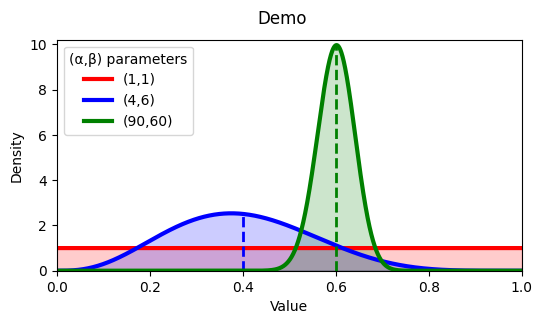

In [10]:
figure, axis = plt.subplots(1, sharex=True, figsize=(6,3))
draw_beta_dist(axis, params = [(1, 1),(4,6),(90,60)])
figure.suptitle('Demo')
axis.set_xlabel('Value')
axis.set_ylabel('Density')
figure.show()

<b>Initially we have no idea what the probability is of any given socket producing an output, so we can start by setting both ‘α’ and ‘β’ to one</b>, which produces a flat line Uniform distribution (<font color='brown'>shown as the flat, red, line in figure 5.1</font>).

<b>This initial guess at the probability of the socket producing an output is known as the [Prior Probability](https://en.wikipedia.org/wiki/Prior_probability)</b>; it is the probability of the specific event occurring before we have collected any evidence and in this case is represented by the Beta distribution `Beta(1,1)`.

**Once we test a socket, and obtain a reward, we can modify our belief in the likelihood of that socket returning some charge. This new probability, after some evidence has been collected, is known as the [Posterior Probability](https://en.wikipedia.org/wiki/Posterior_probability)**. Again this is given by a Beta distribution, but now the values of ‘α’ and ‘β’ are updated with the value of the returned reward.

So, if a socket returns some charge, the reward will be 1 and ‘α’, the count of the number of successes, will increment by 1. The count of the number of failures, ‘β’, will not increase. If instead no reward was obtained, then ‘α’ will stay the same and ‘β’ will increment by 1. <b>As more data is collected the Beta distribution moves from being a flat line to become an increasingly accurate model of the probability of the mean reward. By maintaining the values of ‘α’ and ‘β’ a Thompson sampling algorithm is able to describe the estimated mean reward and the level of confidence in this estimate</b>.

In contrast to the Greedy algorithm, which at each time step selects the action with the highest estimated reward, even if the confidence in that estimate is low, <b>Thompson sampling instead samples from the Beta distribution of each action and chooses the action with the highest returned value. Since actions that have been tried infrequently have wide distributions<b> (<font color='brown'>see the blue curve in figure 5.1</font>)<b>, they have a larger range of possible values. In this way, a socket that currently has a low estimated mean reward, but has been tested fewer times than a socket with a higher estimated mean, can return a larger sample value and therefore become the selected socket at this time step.</b>
    
In the graph above, the blue curve has a lower estimated mean reward than the green curve. Therefore, under Greedy selection, green would be chosen and the blue socket would never be selected. In contrast, Thompson Sampling effectively considers the full width of the curve, which for the blue socket can be seen to extend beyond that of the green socket. In this case the blue socket may be selected in preference to the green one.
    
<b>As the number of trials of a socket increases the confidence in the estimated mean increases</b>. This is reflected in the probability distribution becoming narrower and the sampled value will then be drawn from a range of values that are closer to the true mean (<font color='brown'>see the green curve in figure 5.1</font>). <b>As a result, exploration decreases and exploitation increases, since the sockets with a higher probability of returning a reward will begin to be selected with increasing frequency</b>.
    
<b>On the other hand, sockets with a low estimated mean will start to be selected less frequently and will tend to be dropped early from the selection process</b>. Consequently, their true mean may never be found. Since we are only interested in finding the socket with the highest probability of returning a reward, and finding it as quickly as possible, we don’t care if full information of poorly performing sockets is never obtained.

<a id='sect1_2'></a>
### <font color='darkgreen'>Bernoulli Socket Implementation</font> ([back](#sect1))
As in the socket experiments we carried out in previous parts of this series, we will be using a basic socket class, on top of which we add the specific functionality for the algorithm being studied. Then, using this new class, we run it through a set of experiments using the same test harness for all bandit algorithms. 

Full details of the power socket base class and the accompanying test system are given in [Part 2](https://towardsdatascience.com/multi-armed-bandits-part-2-5834cb7aba4b) of this series and all the code can be found on [github](https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits).

The implementation of Bernoulli Thompson sampling, as described above, is shown in the <b><font color='blue'>BernoulliThompsonSocket</font></b> class:

In [ ]:
class BernoulliThompsonSocket(socket_utils.PowerSocket):
    def __init__(self, q):             
                
        self.α = 1  # the number of times this socket returned a charge        
        self.β = 1  # the number of times no charge was returned
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)          
    
    def charge(self):        
        """ return some charge with the socket's predefined probability """
        return np.random.random() < self.q
                    
    def update(self, R):
        """ increase the number of times this socket has been used and 
            update the counts of the number of times the socket has and 
            has not returned a charge (alpha and beta)"""
        self.n += 1    
        self.α += R
        self.β += (1-R)
        
    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.α, self.β)

In this class we initialise ‘α’ and ‘β’ to one, to give the Uniform Distribution. Then, when updating, we simply increment ‘α’ if the socket returned a reward, otherwise we update ‘β’.

The “sample” function draws a value from the Beta distribution, using the current values of ‘α’ and ‘β’ as its parameters.

<a id='sect1_3'></a>
### <font color='darkgreen'>Experiment Results</font> ([back](#sect1))
The evolution of the Beta distribution for each power socket, where we are using the simpler probabilistic power sockets, can be seen in Figure 5.2 below.

<b>To keep things simple, we’ve reduced the number of sockets to three and these have true probabilities 0.3</b> (green), <b>0.7</b> (red) <b>and 0.8</b> (blue) <b>of returning some power when tested</b>.

In figure below, the true means of 0.3, 0.7 and 0.8 are shown by the dashed lines. The legend displays the number of trials for each socket and the number of successes that have resulted from these trials.

In [ ]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed) 
np.random.seed(seed)

# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.7,0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
fig, axs = plt.subplots(4, 2, figsize=(8, 14))

for j, i in enumerate(draw_samples):
    for k in range(i):
        # choose the socket with the current highest sampled value or
        # arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample() for socket in sockets])     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)            
        
    ax = axs[j%4, j//4]
    plot_sockets(ax, sockets, socket_probabilities)
    
    plt.autoscale(tight = True)
    
#plt.tight_layout()

The main points to note from figure above are the following:
* At time step 0 (<font color='brown'>not shown</font>) all Beta distributions will have their α and β values set to one, to give a flat Uniform distribution.
* **1 Trials**: Since all sockets have the same initial distribution, at time step 1 the blue power socket is selected arbitrarily. When tested it gives a reward, so its α value gets incremented by 1 and its probability density curve shifts to the right. The green and red sockets have not yet been tested, so retain their initial flat distribution (<font color='brown'>with the green curve being hidden behind the red curve</font>).
* **2 Trials**: At the second time step the green socket is selected and miss to gain a reward. The green curve squeezes slightly more to the left and the possibility for green socket to be selected next time will be less.
* **5 Trials**: The means of blue and red socket are gradually moving toward right while the mean of green socket stay in the position from first selection. 
* **At 15 trials** the red socket has now been tried a couple of times. Since it’s returned a reward once, it has an estimated mean reward probability of 0.5. At this stage the blue socket has been tried 11 times and has returned a reward on 6 of these trials, giving it a slightly higher estimated reward probability of 0.54. In a Greedy system the blue socket would therefore be the chosen socket, however because the red socket has been tried less times than the blue socket, it can be seen to have a much wider probability density curve, giving it a good chance of being selected in preference to the blue socket.
* **The more times a socket is tested, the more confident we are in its estimate and the narrower its probability density curve becomes**. The best socket will then be used more often and testing of the sub-optimal sockets will tail off. This behaviour can be seen at the end of our test, when the blue socket has been tried much more often than either of the two other sockets. It can also be seen that the green socket did finally return a reward on 2 of its trials. Consequently, it’s no longer possible that this is a socket that never returns a reward, so the probability of this happening (returning a reward with probability = 0) drops to zero.
* **It can also be seen that neither the blue nor red sockets have probability density curves centred exactly on their true mean probabilities**. If the test was run for more time steps then the blue curve would eventually settle on the true mean value, but the red socket will have a greatly reduced number of trials (if any) and so may never come to find its true value. As mentioned, this isn’t an issue, since we’re only interested in finding the best socket, not the true mean values of the other sockets.

<a id='sect2'></a>
## <font color='darkblue'>Gaussian Thompson Sampling</font>
* <font size='3ptx'><b><a href='#sect2_1'>Gaussian Socket Implementation</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>Experiment Results</a></b></font>

<font size='3ptx'>The simplified socket problem we’ve used so far is a good way to grasp the concepts of Bayesian Thompson Sampling. However, to use this method with our actual socket problem, <b>in which the sockets aren’t binary, but instead return a variable amount of charge, we need to change things slightly</b>.</font>

In the previous problem we modelled the socket’s behaviour using a Beta distribution. This was chosen because the simplified socket output had only two possible outcomes, some charge or no charge, and could therefore be described using a [**Bernoulli distribution**](https://en.wikipedia.org/wiki/Bernoulli_distribution). When a value drawn from a [**Bernoulli distribution**](https://en.wikipedia.org/wiki/Bernoulli_distribution) (<font color='brown'>the likelihood value</font>) is multiplied by a value drawn from a [**Beta distribution**](https://en.wikipedia.org/wiki/Beta_distribution) (<font color='brown'>the prior probability</font>), then the resultant value (<font color='brown'>the posterior probability</font>) also has a [**Beta distribution**](https://en.wikipedia.org/wiki/Beta_distribution). When this occurs, such that the likelihood multiplied by the prior results in a posterior with the same distribution type as the prior, the prior is referred to as a [**Conjugate Prior**](https://en.wikipedia.org/wiki/Conjugate_prior).

**With our standard socket problem, each socket returns a real value described by a normal distribution. If we assume we know the variance of our socket** (<font color='brown'>which is actually 1, since we use an unmodified version of the [numpy randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) function in our code</font>)**, then from the table of conjugate priors on Wikipedia we can see that the conjugate prior also has a normal distribution**. If we don’t know the variance of our distribution, or we’re using a different distribution, then we simply need to pick one of other conjugate priors from the table and adjust our algorithm accordingly.

**So we can model the output of a socket using a normal distribution and gradually refine this model by updating its mean and variance parameters**. If, instead of using the variance, we use the precision ‘τ’ (tau), where precision is just one over the variance (<font color='brown'>precision τ = 1/variance</font>), then we can use the simple update rules for the mean ‘μ₀’ and total precision ‘τ₀’ given by:
$$τ₀ << τ₀ + nτ$$

$$μ₀ << \frac{μ₀τ₀ + τ}{τ₀ + nτ\sum_{i=0}^{n}x_i}$$

* ‘τ’ is the precision of the actual socket output, which in our case is just 1.
* ’n’ is the number of times the socket has been tested.
* ‘xᵢ’ is the output received at each test ‘i’ of this socket (equivalent to the reward ‘Rᵢ’ that we’ve used up till now).
* ‘μ₀’ is the estimated mean (the mean of the distribution used to model the output).
* ‘τ₀’ is the total precision of the distribution used to model the output.

At a first glance this looks rather intimidating, but all it’s basically saying is that we have 2 parameters ‘μ₀’ and ‘τ₀’ that we’ll update each time we test a socket, just as we did with ‘α’ and ‘β’ for the Bernoulli socket. Except **in that case those parameters represented the number of successes and failures of the socket, whereas ‘μ₀’ and ‘τ₀’ represent the estimated mean and the precision, representing the confidence in the estimated mean**.

Additionally we can make a couple of other simplifications:
* We know that the amount of charge returned from a socket has a variance of 1 and so the precision ‘τ’ is also 1. Therefore the update of the socket precision is simply $τ₀ = τ₀ + n$, where n is the number of times the socket has been tested, so each time a socket gets tested we simply increment its precision by 1.
* For the estimated mean the numerator contains a sum over all of the outputs produced by the socket, multiplied by ‘τ’. As we saw way back in the Sample Average Estimates section of Part 1, it’s not a good idea to retain the sum of rewards, since this could potentially grow to an unmanageable size. However, in our base socket implement we always calculate ‘Qₜ(a)’, the estimated value of action ‘a’ at time step ‘t’, which is given by: $Q_t(a) = \frac{1}{n}\sum_{i=1}^{n}R_I$
* In this equation ‘Rᵢ’ is the reward obtained at each of the time steps when action ‘a’ was taken and is identical to the term ‘xᵢ’ used in the update equation above. Therefore we can simply replace the summation in the update equation with ‘nQₜ(a)’ and end up with the following simplified update equation:
> <font size='3ptx'> $μ₀ < \frac{μ₀τ₀ + nQ_t(a)}{τ₀ + n} $ </font>

With these simplifications we tame the scary mathematics! It’s now clear that all we need to do is to keep estimates of the mean and precision of the reward from each socket and then use 2 simple rules to update these values. Things become even clearer when these equations are translated into code.

<a id='sect2_1'></a>
### <font color='darkgreen'>Gaussian Socket Implementation</font>
The associated code for a Gaussian Thompson sampling socket is shown below. This retains all of the basic functionality we’ve used in previous socket types and adds the parameters and update function for the posterior distribution that is used to model the socket output.

Note that in this update function we’ve replaced the summation over all of the observed rewards with `self.n * self.Q`. This gives us exactly the same value without having to retain the sum of rewards which, as described previously, could potentially grow to an unmanageable size.

The two update functions, given in the equations above, translate into the simple lines of code shown in the update function.

In [12]:
class GaussianThompsonSocket(socket_utils.PowerSocket):
    def __init__(self, q):                                
        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
    def sample(self):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0    
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """   
        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1      

The other main points to note are:
* The ‘sample’ function, instead of simply returning ‘Q’, the estimate of the socket’s reward value, instead returns a value sampled from the normal distribution that we’re using to model the socket output (<font color='brown'>the posterior, with mean `self.μ_0` and precision `self.τ_0`</font>).
* <b>As with the Beta distribution, used to model the socket output for binary outputs, we want our prior distribution to start with a distribution that’s close to the uniform distribution</b>, giving a flat probability distribution curve and therefore the potential to return a sampled value with a wide range of possible values. So, initially we set the precision of the posterior to be a very small value (`self.τ_0 = 0.0001`). <b>In this way sockets that have not yet been tried will be more likely to be selected, much like the Optimistic-Greedy algorithm</b>.


If you look back at the code for the base power socket, **when a socket is sampled it returns an amount of charge given by a normal distribution around its true mean value**:
```python

    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true value 'q'
        value = np.random.randn() + self.q 
```

In the charge function above, The numpy “[randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)” function returns a random value from a normal distribution of mean 0 and variance 1. By adding the true socket reward value `q` to this, we shift the mean to get the distribution to be centred on the actual output of the socket.

In the sample function of the Thompson socket a very similar function can be seen:
```python
    def sample(self):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0 
```

Except in this case the normal is centred on `self.μ_0`, the posterior mean. Additionally, it can be seen that [randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) is now divided by the square root of the posterior precision `self.τ_0`. Remember that the precision is just one over the variance and that variance is the standard deviation squared. Therefore dividing by the square root of the precision is identical to multiplying by the standard deviation. This is what changes the width of the distribution, reducing it as more samples occur and we become more confident in our estimated mean.

<a id='sect2_2'></a>
### <font color='darkgreen'>Experiment Results</font>
As with the Bernoulli experiment done previously, we’ve observed the socket selection over 1000 trials, as shown by the probability density curves below. Due to the posterior distributions starting out with almost flat curves, each of the 5 sockets gets tested once during the first 5 trials. After this, socket 4 (<font color='brown'>shown as the red curve</font>) dominates the further trials. By the end of the tests it has a tall, thin, curve centred on a value of 12 (<font color='brown'>the true socket reward value</font>) indicating a high level of confidence in this value.

The only other socket that is tested more than once, over the first 200 tests, is socket 5 (<font color='brown'>the purple curve, which has a true socket reward of 10</font>). However, it is only tested 3 times and therefore has a small, fat, distribution curve, indicating a low confidence in its value.

True Values = [6, 4, 8, 12, 10]


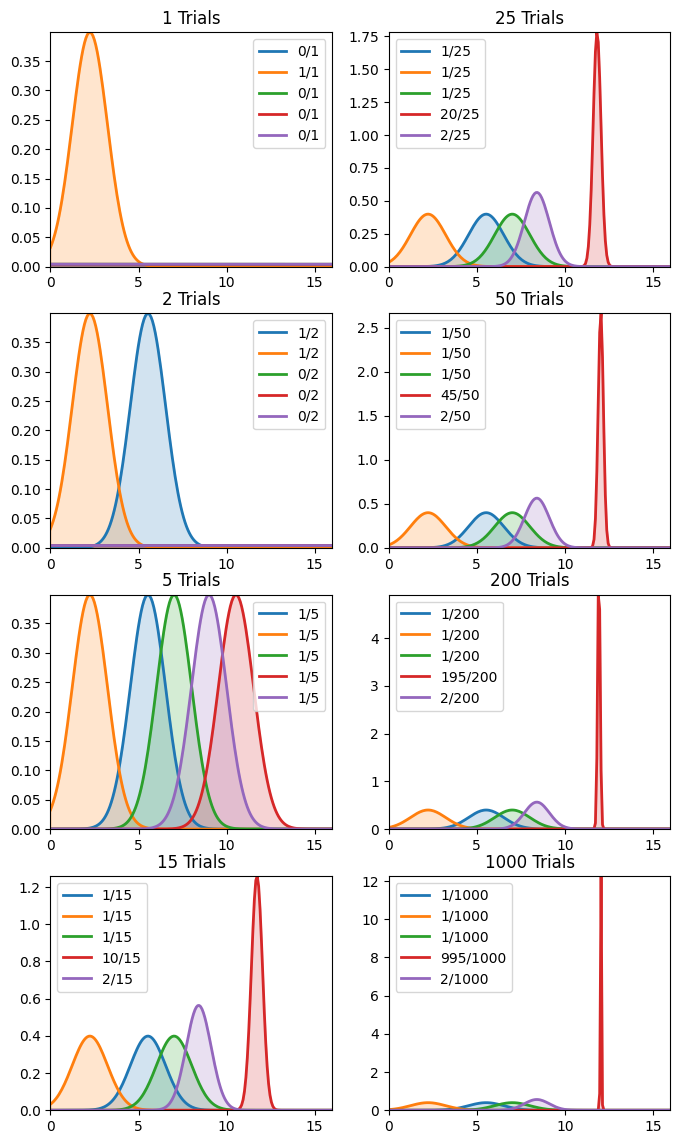

In [19]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed) 
np.random.seed(seed)

# create 5 sockets in a fixed order
socket_order = [2, 1, 3, 5, 4]

socket_true_values = [((q*2)+2) for q in socket_order]

print(f"True Values = {socket_true_values}")

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [GaussianThompsonSocket(q) for q in socket_true_values]
fig, axs = plt.subplots(4, 2, figsize=(8, 14))

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j, i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    
    for k in range(i):
        
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_samples = [socket.sample() for socket in sockets]
        socket_index = random_argmax(socket_samples)     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)            
        
    ax = axs[j % 4, j // 4]
    plot_nd_sockets(ax, sockets, socket_true_values)
    
    plt.autoscale(tight = True)

From figure above, it is clear to see how <b>Thompson sampling quickly locates and then exploits the best socket, with the other sockets being left largely untested</b>. In this way the algorithm manages to return a large, and nearly optimal, accumulated reward.

<a id='sect3'></a>
## <font color='darkblue'>Thompson Sampling Regret</font>
The regret obtained when using the Thompson Sampling algorithm with our standard socket selection problem is shown in figure below.
![TSR](images/2.PNG)

As was seen for the [**UCB algorithm**](https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f), the regret is practically zero, meaning that the best socket was nearly always chosen. This can also be seen in the plot of Cumulative Reward vs Time, in which the actual obtained reward is such a close match for the optimal that it obscured by this curve on the graph. **As was seen with the probability density curves for Gaussian Thompson Sampling, the algorithm quickly locks onto the best action and then ruthlessly exploits this, resulting in a very low level of regret**.

For a more in-depth look at Thompson Sampling, its uses and mathematical framework check out the following:
* [“A Tutorial on Thompson Sampling” Daniel J. Russo, et al.](http://a%20tutorial%20on%20thompson%20sampling%20daniel%20j.%20russo1/)

<a id='sect4'></a>
## <font color='darkblue'>Summary</font> ([back](#sect0))
<b><font size='3ptx'>Algorithms that solve the bandit problem need to find a way to balance the trade-off between exploitation and exploration. They need to look for the best actions to take while at the same time trying to make use of the information they’ve already gained.</font></b>

In simple approaches, such as Epsilon-Greedy, this trade-off is achieved by mainly using the action that currently gives the most reward and adding simple exploration by now and again randomly trying some of the other actions. In more complex solutions, such as UCB, again the actions with the highest mean reward are selected most often but this is balanced by a confidence measure. This ensures that actions that have not been selected often will get tested.

Thompson Sampling takes a different approach to these other methods. Instead of simply maintaining an estimate of the reward, it gradually refines a model of the probability of the reward for each action and actions are chosen by sampling from this distribution. It is therefore possible to get an estimate for the mean reward value of an action, plus a measure of confidence for that estimate. As we saw in our experiments, this allows it to quickly locate and lock onto the optimal action, to give a near optimal accumulated return.

<b>But is Thompson Sampling the best bandit algorithm and, more importantly, is it the one we should use to charge Baby Robot? To know the answers to these questions you’ll need to wait until the [final part of this series](https://towardsdatascience.com/a-comparison-of-bandit-algorithms-24b4adfcabb), when we have the bandit algorithms go head-to-head in a final showdown!</b>